<a href="https://colab.research.google.com/github/intimanjunath/Neural-network-using-numpy-keras-pytorch-and-jax/blob/main/1_NumPy_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Generate Synthetic Data & 4D Visualization

In this cell we define a non‑linear function of three variables, generate 1000 samples, and plot a 3D scatter plot (with color representing the target value).

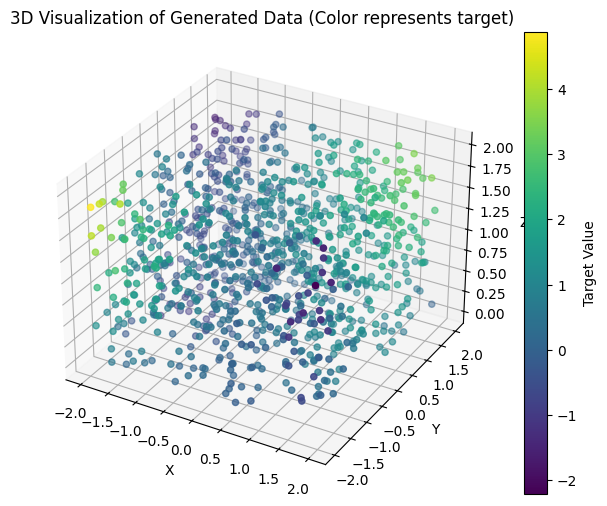

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

# Define the non-linear function with three variables
def nonlinear_function(x, y, z):
    # Example function: sin(x)*cos(y) + log(z+1) + 0.5*x*y*z
    return np.sin(x) * np.cos(y) + np.log(z + 1) + 0.5 * x * y * z

# Generate synthetic data
np.random.seed(42)
num_samples = 1000

# Generate random samples for x, y in [-2, 2] and z in [0, 2] (z non-negative for log stability)
X = np.random.uniform(-2, 2, num_samples).reshape(-1, 1)
Y = np.random.uniform(-2, 2, num_samples).reshape(-1, 1)
Z = np.random.uniform(0, 2, num_samples).reshape(-1, 1)

# Compute target values using the non-linear function
target = nonlinear_function(X, Y, Z)

# 4D Plot: Visualize the 3 input dimensions in 3D and use color to represent the target value.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X, Y, Z, c=target, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.colorbar(sc, label="Target Value")
plt.title("3D Visualization of Generated Data (Color represents target)")
plt.show()

* Data Preprocessing: Normalization & Train-Test Split

We stack the inputs into one array, normalize the features and target, and split the data into training (80%) and testing (20%) sets.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Stack inputs (X, Y, Z) into a single array with shape (num_samples, 3)
X_data = np.hstack((X, Y, Z))

# Normalize inputs and target values using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_data_scaled = scaler_X.fit_transform(X_data)
target_scaled = scaler_Y.fit_transform(target)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, target_scaled, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (800, 3) (800, 1)
Testing set shape: (200, 3) (200, 1)


* Initialize the Neural Network Parameters

We define our network architecture (input layer → 2 hidden layers → output layer) and initialize weights and biases with small random values.

In [3]:
# Neural network architecture parameters
input_size = 3      # Three input features: X, Y, Z
hidden_size1 = 10   # First hidden layer neurons
hidden_size2 = 8    # Second hidden layer neurons
output_size = 1     # Single output for regression

# Set random seed for reproducibility
np.random.seed(42)

# Initialize weights and biases using small random values
# Note: When using np.einsum in forward propagation, shape X is (batch, input_size)
W1 = np.random.randn(input_size, hidden_size1) * 0.1  # Shape: (3, 10)
b1 = np.zeros((1, hidden_size1))                        # Shape: (1, 10)

W2 = np.random.randn(hidden_size1, hidden_size2) * 0.1  # Shape: (10, 8)
b2 = np.zeros((1, hidden_size2))                        # Shape: (1, 8)

W3 = np.random.randn(hidden_size2, output_size) * 0.1   # Shape: (8, 1)
b3 = np.zeros((1, output_size))                         # Shape: (1, 1)

# Verify shapes
print("W1 shape:", W1.shape, "| b1 shape:", b1.shape)
print("W2 shape:", W2.shape, "| b2 shape:", b2.shape)
print("W3 shape:", W3.shape, "| b3 shape:", b3.shape)

W1 shape: (3, 10) | b1 shape: (1, 10)
W2 shape: (10, 8) | b2 shape: (1, 8)
W3 shape: (8, 1) | b3 shape: (1, 1)


* Forward Propagation Using Einsum

In this cell we define the activation functions and a forward propagation function. Notice that we use np.einsum for matrix multiplication.

In [4]:
# Define activation functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Forward propagation function using np.einsum for matrix multiplication
def forward_propagation(X):
    # Layer 1: Compute Z1 = X*W1 + b1 then apply ReLU activation
    Z1 = np.einsum('ij,jk->ik', X, W1) + b1  # (batch, hidden_size1)
    A1 = relu(Z1)

    # Layer 2: Compute Z2 = A1*W2 + b2 then apply ReLU activation
    Z2 = np.einsum('ij,jk->ik', A1, W2) + b2  # (batch, hidden_size2)
    A2 = relu(Z2)

    # Output Layer: Compute Z3 = A2*W3 + b3 then apply Sigmoid activation
    Z3 = np.einsum('ij,jk->ik', A2, W3) + b3  # (batch, output_size)
    output = sigmoid(Z3)

    return output, (Z1, A1, Z2, A2, Z3)

# Test the forward pass on the training data
y_pred_train, cache = forward_propagation(X_train)
print("Sample predicted output (first 5):", y_pred_train[:5].flatten())

Sample predicted output (first 5): [0.49995511 0.49985919 0.49990568 0.49997294 0.4998682 ]


* Backpropagation Implementation & Training Loop

Here we compute the gradients using the chain rule and update the weights using gradient descent. We track the training loss over epochs.

In [5]:
# Define Mean Squared Error (MSE) loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Define derivative of the sigmoid function (assuming input is already sigmoid-activated)
def sigmoid_derivative(s):
    return s * (1 - s)

# Training hyperparameters
learning_rate = 0.01
epochs = 1000

loss_history = []

# Training loop using manual backpropagation
for epoch in range(epochs):
    # Forward propagation
    y_pred, (Z1, A1, Z2, A2, Z3) = forward_propagation(X_train)

    # Compute loss
    loss = mse_loss(y_train, y_pred)
    loss_history.append(loss)

    # Backpropagation:
    # Output layer error and gradients
    dZ3 = (y_pred - y_train) * sigmoid_derivative(y_pred)
    dW3 = np.einsum('ij,ik->jk', A2, dZ3) / X_train.shape[0]
    db3 = np.mean(dZ3, axis=0, keepdims=True)

    # Backpropagate to second hidden layer
    dA2 = np.einsum('ik,jk->ij', dZ3, W3.T)
    dZ2 = dA2 * (Z2 > 0)  # ReLU derivative
    dW2 = np.einsum('ij,ik->jk', A1, dZ2) / X_train.shape[0]
    db2 = np.mean(dZ2, axis=0, keepdims=True)

    # Backpropagate to first hidden layer
    dA1 = np.einsum('ij,jk->ik', dZ2, W2.T)
    dZ1 = dA1 * (Z1 > 0)  # ReLU derivative
    dW1 = np.einsum('ij,ik->jk', X_train, dZ1) / X_train.shape[0]
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    # Update weights and biases using gradient descent
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5f}")

print(f"Final Training Loss: {loss_history[-1]:.5f}")

Epoch 0, Loss: 0.02838
Epoch 100, Loss: 0.02739
Epoch 200, Loss: 0.02652
Epoch 300, Loss: 0.02575
Epoch 400, Loss: 0.02507
Epoch 500, Loss: 0.02447
Epoch 600, Loss: 0.02394
Epoch 700, Loss: 0.02348
Epoch 800, Loss: 0.02307
Epoch 900, Loss: 0.02271
Final Training Loss: 0.02240


* Model Evaluation on Test Data

We now run the trained model on the test set, compute the test loss, and compare a few sample predictions to the actual values. Note that we inverse-transform the normalized targets back to their original scale.

In [6]:
# Perform forward propagation on the test set
y_test_pred, _ = forward_propagation(X_test)
test_loss = mse_loss(y_test, y_test_pred)
print(f"Test Loss: {test_loss:.5f}")

# Inverse transform the normalized values back to the original scale
y_test_original = scaler_Y.inverse_transform(y_test)
y_test_pred_original = scaler_Y.inverse_transform(y_test_pred)

# Display first 5 predictions vs. actual values
print("\nFirst 5 Test Predictions vs Actual Values:")
for i in range(5):
    print(f"Predicted: {y_test_pred_original[i][0]:.4f}, Actual: {y_test_original[i][0]:.4f}")

Test Loss: 0.02298

First 5 Test Predictions vs Actual Values:
Predicted: 1.0309, Actual: 0.2030
Predicted: 1.0313, Actual: 0.2209
Predicted: 1.0316, Actual: 0.4391
Predicted: 1.0320, Actual: 0.0548
Predicted: 1.0275, Actual: -0.1271


* Visualize the Training Loss Curve

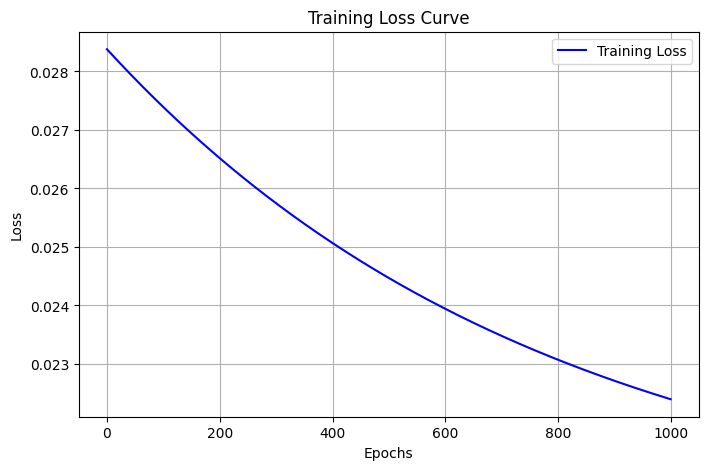

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()